# Term Subscription Predictions and Customer Analysis
### Final Model Notebook
##### Brittany Allen, February 2019

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#importing the usual suspects (packages/libraies)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
#scikit-learn libraries/packages

#from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
#classification packages

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation
from keras import regularizers
from keras.callbacks import EarlyStopping
#neural net libraries/packages

import random
#so I can set a random seed y'all

import warnings
warnings.simplefilter(action='ignore')
#preventing those ugly pink warnings from printing out

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#displayng my plots inline and changing the inline backeng default figure format so it's cleaner

In [35]:
random.seed(42)

#setting a global random seed for reproducibility

In [36]:
bmd_df = pd.read_csv('./bank.csv')

#reading in my DataFrame and assigning it the variable 'bmd_df' – which stands for bank marketing DataFrame

In [37]:
bmd_df = bmd_df.drop(columns='duration')

#dropping this feature as it is known to highly influence the target

In [38]:
bmd_df.head()

#displaying the first five rows of my DataFrame

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,2,-1,0,unknown,yes


In [39]:
bmd_df.shape

#checking out the shape of my DataFrame

(11162, 16)

In [40]:
bmd_df.isnull().sum().sum()

#checking for nulls, there are none

0

In [41]:
bmd_df.deposit.value_counts(normalize=True)

#checking out the distribution of my target variable

no     0.52616
yes    0.47384
Name: deposit, dtype: float64

In [42]:
bmd_df['target'] = bmd_df.deposit.map(lambda x: 1 if x == 'yes' else 0)

#converting my target variable into '1s' and '0s' for my binary classification algorithms

In [43]:
b = [18, 35, 50, 72, 90, np.inf]
names = ['Millennials (18-34)', 
         'Gen X (35-49)',
         'Baby Boomers (50-71)',
         'Silent Gen (72-89)',
         'GI Gen (90+)']

bmd_df['age_group'] = pd.cut(x = bmd_df.age, bins = b, labels = names, right=False)

I engineered a new feature above, <b>age_group</b>, to bucket customers by their generational age groups as I think it will make data visualization and analysis easier and more meaningful.

In [44]:
bmd_df.head()

#displaying my head again to get a glimpse of the new feature I engineered

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit,target,age_group
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1,-1,0,unknown,yes,1,Baby Boomers (50-71)
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1,-1,0,unknown,yes,1,Baby Boomers (50-71)
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1,-1,0,unknown,yes,1,Gen X (35-49)
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,1,-1,0,unknown,yes,1,Baby Boomers (50-71)
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,2,-1,0,unknown,yes,1,Baby Boomers (50-71)


# Feature Selection / Engineering / Transformation

In [45]:
bmd_df.columns

#getting a look at all of my columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign', 'pdays', 'previous',
       'poutcome', 'deposit', 'target', 'age_group'],
      dtype='object')

In [46]:
to_poly = bmd_df.columns[bmd_df.dtypes != object]
to_poly = to_poly.drop(labels=['target', 'age_group'])

#creating a variable to house the features I'd like to create mass polynomial and interaction terms for

In [47]:
poly = PolynomialFeatures(include_bias=False)
X_poly = bmd_df[to_poly]

#instantiating the PolynomialFeatures pre-processor
#assigning a variable, X_poly, to house the DataFrame of features to be processed

In [48]:
X_poly = poly.fit_transform(X_poly)

#fitting and transforming my features

In [49]:
poly.get_feature_names(to_poly)

#displaying the feature names of my newly created polynomial and interaction terms

['age',
 'balance',
 'day',
 'campaign',
 'pdays',
 'previous',
 'age^2',
 'age balance',
 'age day',
 'age campaign',
 'age pdays',
 'age previous',
 'balance^2',
 'balance day',
 'balance campaign',
 'balance pdays',
 'balance previous',
 'day^2',
 'day campaign',
 'day pdays',
 'day previous',
 'campaign^2',
 'campaign pdays',
 'campaign previous',
 'pdays^2',
 'pdays previous',
 'previous^2']

In [50]:
bmd_df_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names(to_poly))
bmd_df = bmd_df.join(bmd_df_poly[['age^2', 'age balance', 'age day', 'age campaign', 'age pdays', 'age previous',
                            'balance^2', 'balance day', 'balance campaign', 'balance pdays', 'balance previous',
                            'day^2', 'day campaign', 'day pdays', 'day previous', 'campaign^2', 'campaign pdays',
                            'campaign previous', 'pdays^2', 'pdays previous', 'previous^2']])
bmd_df.head()

#created a new DataFrame to house my new polynomial and interaction terms
#joined that new Dataframe with my existing one, bmd_df, and displayed the head to review the results

,age,job,marital,education,default,balance,housing,loan,contact,day,...,day^2,day campaign,day pdays,day previous,campaign^2,campaign pdays,campaign previous,pdays^2,pdays previous,previous^2
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,...,25.0,5.0,-5.0,0.0,1.0,-1.0,0.0,1.0,-0.0,0.0
1,56,admin.,married,secondary,no,45,no,no,unknown,5,...,25.0,5.0,-5.0,0.0,1.0,-1.0,0.0,1.0,-0.0,0.0
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,...,25.0,5.0,-5.0,0.0,1.0,-1.0,0.0,1.0,-0.0,0.0
3,55,services,married,secondary,no,2476,yes,no,unknown,5,...,25.0,5.0,-5.0,0.0,1.0,-1.0,0.0,1.0,-0.0,0.0
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,...,25.0,10.0,-5.0,0.0,4.0,-2.0,0.0,1.0,-0.0,0.0


In [51]:
to_dummy = (bmd_df.columns[bmd_df.dtypes != float]) & (bmd_df.columns[bmd_df.dtypes != int])
to_dummy = to_dummy.drop(labels='deposit')

#created a variable to house the categorical features I wanted to pre-process with one-hot encoding
#dropped my target variable

In [52]:
bmd_df = pd.get_dummies(bmd_df, columns=to_dummy, drop_first=True)
bmd_df.head()

#used Pandas' pd.get_dummies to transform my features into binary values and reassigned it back to my DataFrame

,age,balance,day,campaign,pdays,previous,deposit,target,age^2,age balance,...,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,age_group_Gen X (35-49),age_group_Baby Boomers (50-71),age_group_Silent Gen (72-89),age_group_GI Gen (90+)
0,59,2343,5,1,-1,0,yes,1,3481.0,138237.0,...,0,0,0,0,0,1,0,1,0,0
1,56,45,5,1,-1,0,yes,1,3136.0,2520.0,...,0,0,0,0,0,1,0,1,0,0
2,41,1270,5,1,-1,0,yes,1,1681.0,52070.0,...,0,0,0,0,0,1,1,0,0,0
3,55,2476,5,1,-1,0,yes,1,3025.0,136180.0,...,0,0,0,0,0,1,0,1,0,0
4,54,184,5,2,-1,0,yes,1,2916.0,9936.0,...,0,0,0,0,0,1,0,1,0,0


In [53]:
features = bmd_df.columns.drop(labels = ['deposit', 'target', 'age', 'balance', 
                                         'day', 'campaign','pdays', 'previous'])
features

#created a variable to house the features I planned to model with

Index(['age^2', 'age balance', 'age day', 'age campaign', 'age pdays',
       'age previous', 'balance^2', 'balance day', 'balance campaign',
       'balance pdays', 'balance previous', 'day^2', 'day campaign',
       'day pdays', 'day previous', 'campaign^2', 'campaign pdays',
       'campaign previous', 'pdays^2', 'pdays previous', 'previous^2',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes',
       'loan_yes', 'contact_telephone', 'contact_unknown', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown',
       'a

In [54]:
bmd_df.shape

#checking out the shape of my DataFrame now that new features have been added

(11162, 68)

In [55]:
X = bmd_df[features]
y = bmd_df.target

#creating my X and y variables

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=44, test_size=0.30)

#instantiating my train test split, passing the data to be split, setting a random state, and specifying my test size

In [57]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

#scaling my Xs

# CLASSIFICATION MODELING

### BEST LOGISTIC REGRESSION MODEL

In [58]:
lr = LogisticRegression(C= 1.5, class_weight= None, penalty= 'l2', 
                        random_state= 42, solver= 'lbfgs', warm_start= True)

#instantiating my logistic regression model and assigning it to a variable, lr

In [59]:
lr.fit(X_train, y_train)
#fitting my model to my data
     
print(f'Train score = {lr.score(X_train, y_train)}')
print(f'Test score = {lr.score(X_test, y_test)}')
#scoring my model on my training and test data and printing the results of each
    
lr_preds = lr.predict(X_test)
#storing my predictions to a variable

print('--------')
print(confusion_matrix(y_test, lr_preds))
#printing out a confusion matrix

Train score = 0.7156022014591066
Test score = 0.7121528814571514
--------
[[1439  299]
 [ 665  946]]


In [60]:
sorted(list(zip(np.exp(lr.coef_[0]),X.columns)), reverse=True)[:15]

#checking out my coefficents and the feature the correspond to

[(1.9005179248542623, 'poutcome_success'),
 (1.6191127562056487, 'age previous'),
 (1.2769597950993066, 'month_mar'),
 (1.18164476895188, 'age^2'),
 (1.173224743976489, 'month_oct'),
 (1.1718787806992124, 'day pdays'),
 (1.1643144959885854, 'age balance'),
 (1.157655752719762, 'education_tertiary'),
 (1.150964673105784, 'month_dec'),
 (1.115553562299469, 'campaign^2'),
 (1.1118611943962393, 'job_student'),
 (1.1073427244855043, 'month_sep'),
 (1.1022667011706002, 'poutcome_unknown'),
 (1.0956394573829475, 'age_group_GI Gen (90+)'),
 (1.0803804616873267, 'education_secondary')]

- As successful outcomes of previous marketing campaigns increase by one unit, a customer is 1.9x as likely to sign up for a term deposit

- As marketing activity increases in the months of March, October, December, and September by one unit respectively a customer is 1.3x, 1.17x, 1.15x, and 1.12x as likely to sign up for a term deposit

- As the level of college education increases by one unit, a customer is 1.16x as likely to sign up for a term deposit

- As the age group, GI Gen (90+), increases by one unit, a customer is 1.10x as likely to sign up for a term deposit

# Principal Component Analysis

In [61]:
def corr_map(data, figsize=(14, 14), mask_val = .5):
    #make a correlation heat map from pandas dataframe
    #pass a value to mask_val to only see correlations above a certain threshold
   
    corr = data.corr()    
    
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(corr)] = True
    #make a mask to only show bottom triangle
    
    if (mask_val != None):
        mask[abs(corr) < mask_val] = True
    #add to the mask (if mask_val passed)
    
    f, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap)
    pass
    #make the correlation heatmap

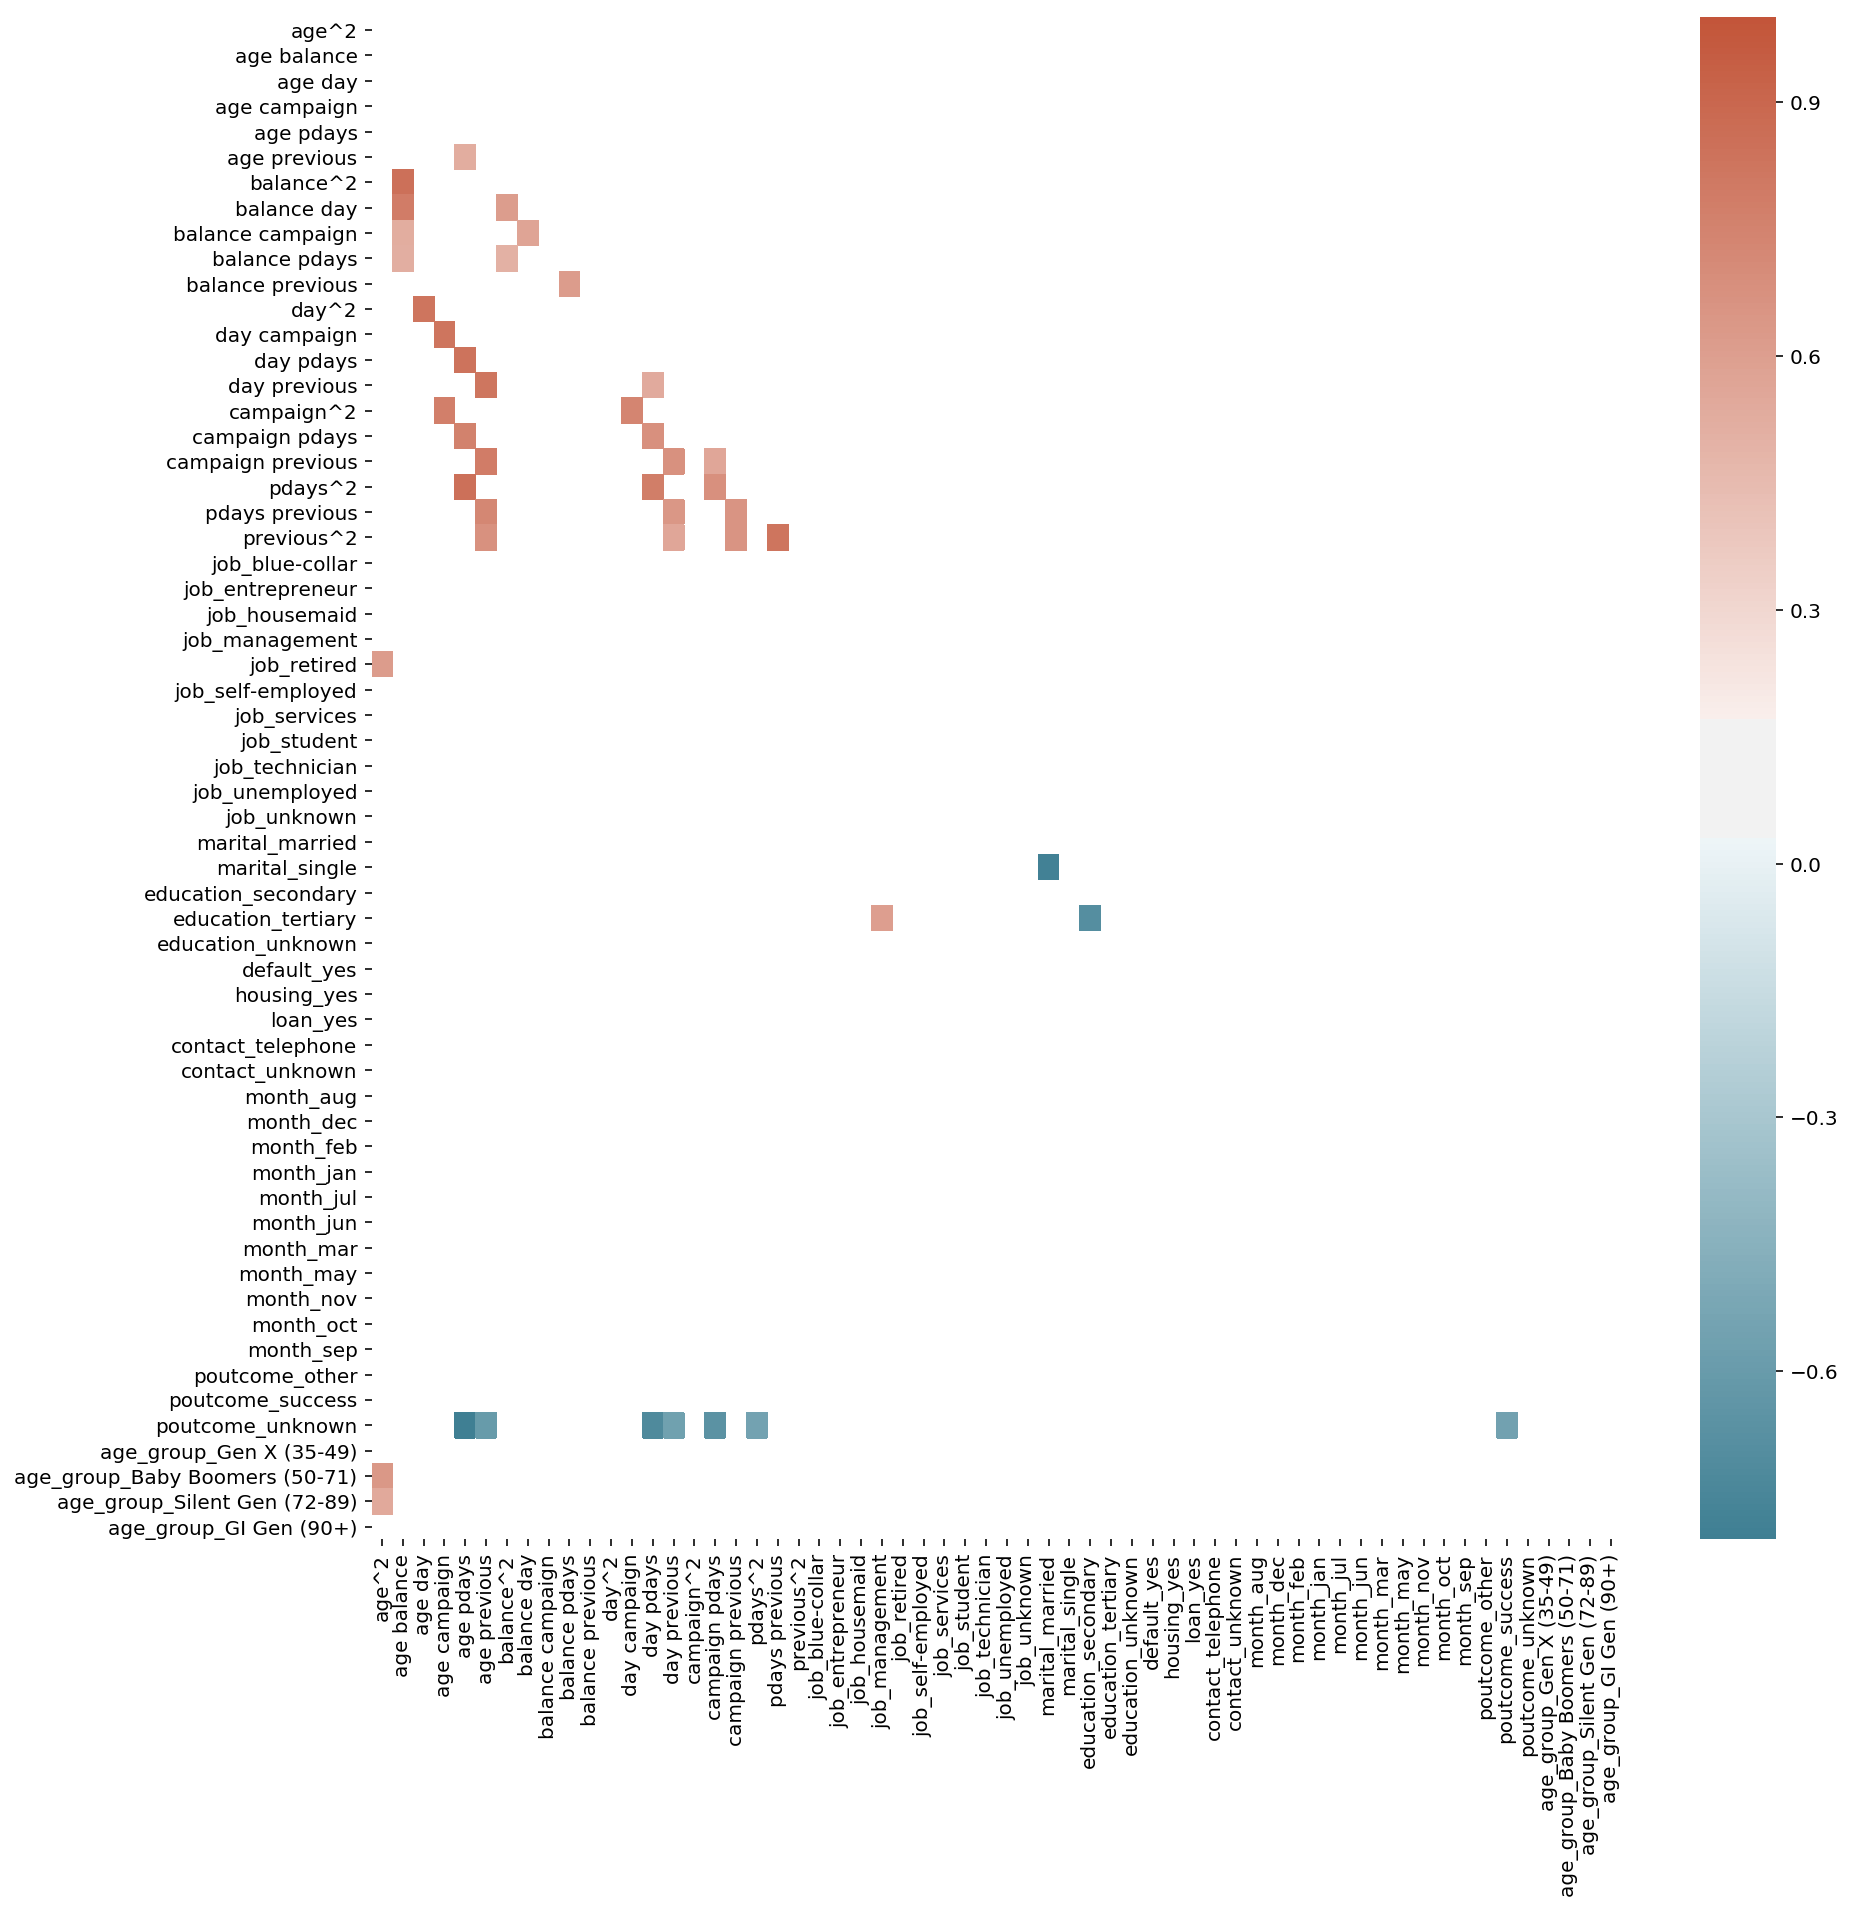

In [62]:
corr_map(bmd_df.drop(columns = ['age', 'balance', 'day', 'campaign', 
                                     'pdays', 'previous', 'deposit', 'target']))
#calling the corr_map function to plot my corraltion heatmap on the features that would be fed into my model

As we can see above there are some features that have -/+ .50 correlations with each other so I am implementing PCA as a method to deal with the multicollinearity. 

In [63]:
pca = PCA(n_components=58)
pca = pca.fit(X_train)

#instantiating PCA, a linear dimensionality reduction and assigning it to a variable, pca
#fitting my X_train data to this

In [64]:
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)

#creating new variables, Z_train and Z_test, to house my newly transformed features

In [65]:
exp_variance = pca.explained_variance_ratio_
print('Explained variance:            ', np.round(exp_variance, 3))
print(' ')
cum_exp_variance = np.cumsum(exp_variance)
print('Cumulative explained variance: ', np.round(cum_exp_variance, 3))

#creating variables to house both explained and cumulative explained variance and printing the results of each

Explained variance:             [0.113 0.068 0.05  0.048 0.043 0.036 0.034 0.032 0.028 0.023 0.023 0.022
 0.021 0.02  0.019 0.019 0.019 0.018 0.018 0.018 0.017 0.017 0.017 0.017
 0.016 0.016 0.016 0.015 0.015 0.015 0.014 0.014 0.013 0.013 0.012 0.011
 0.01  0.009 0.009 0.008 0.008 0.006 0.005 0.004 0.004 0.003 0.003 0.003
 0.003 0.003 0.002 0.002 0.002 0.002 0.001 0.001 0.001 0.001]
 
Cumulative explained variance:  [0.113 0.181 0.231 0.278 0.322 0.358 0.392 0.424 0.451 0.475 0.497 0.52
 0.541 0.56  0.579 0.598 0.617 0.635 0.653 0.671 0.688 0.705 0.722 0.738
 0.755 0.771 0.787 0.802 0.817 0.831 0.845 0.86  0.873 0.885 0.897 0.908
 0.918 0.927 0.936 0.944 0.952 0.958 0.963 0.968 0.971 0.974 0.978 0.981
 0.983 0.986 0.988 0.99  0.992 0.994 0.995 0.996 0.998 0.999]


In [66]:
lr_pca = LogisticRegression(C= 1.5, class_weight= None, penalty= 'l2', 
                        random_state= 42, solver= 'lbfgs', warm_start= True)

lr_pca.fit(Z_train, y_train)
     
print(f'Train score = {lr_pca.score(Z_train, y_train)}')
print(f'Test score = {lr_pca.score(Z_test, y_test)}')
    
lr_pca_preds = lr_pca.predict(Z_test)
print('--------')
print(confusion_matrix(y_test, lr_pca_preds))

#re-ran my logistic regression model with the same parameters from above this time on the newly transformed data
#printed the train and test scores and confusion matrix

Train score = 0.7149622424164853
Test score = 0.7103613018811585
--------
[[1435  303]
 [ 667  944]]


Our model didn't approve after implementing PCA. As you can see from the correlation heatmap above there weren't <b> so many </b> features highly correlated with each other relative to those that were not.